In [16]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time

## Normalize data with testing data
##### use default normalizing condition which is mean, std of mnist training dataset which we use as testing data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])


## Use Mnist train as test and vice versa

In [3]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)


In [4]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())


the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


## Optimization
#### use any stochastic gradient descent algorithm for the optimization
#### use any size of the mini-batch
#### use any optimization algorithm (for example, Momentum, AdaGrad, RMSProp, Adam)
#### use any regularization algorithm (for example, Dropout, Weight Decay)
#### use any annealing scheme for the learning rate (for example, constant, decay, staircase)

## Desigining Model
#### design a neural network architecture with a combination of convolutional layers and fully connected layers
#### use any number of feature layers (convolutional layers)
#### use any size of convolutional kernel_size
#### use any number of classification layers (fully connected layers)
#### use any dimension of classification layers
#### use any type of activation functions
#### one example model of the convolutional neural network is as follows:

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import math

class MyModel(nn.Module):

    def __init__(self, num_classes=10, size_kernel=5):

        super(MyModel, self).__init__()

        # *********************************************************************
        # input parameter
        #
        # data size:
        #   mnist   : 28 * 28
        # *********************************************************************
        self.number_class   = num_classes
        self.size_kernel    = size_kernel        
        
        # *********************************************************************
        # feature layer
        # *********************************************************************
        self.conv1          = nn.Conv2d(1, 20, kernel_size=size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)
        self.conv2          = nn.Conv2d(20, 50, kernel_size=size_kernel, stride=1, padding=int((size_kernel-1)/2), bias=True)

        self.conv_layer1    = nn.Sequential(self.conv1, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))
        self.conv_layer2    = nn.Sequential(self.conv2, nn.MaxPool2d(kernel_size=2), nn.ReLU(True))

        self.feature        = nn.Sequential(self.conv_layer1, self.conv_layer2)
        
        # *********************************************************************
        # classifier layer
        # *********************************************************************
        self.fc1        = nn.Linear(50*7*7, 50, bias=True)
        self.fc2        = nn.Linear(50, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))

        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))

                if m.bias is not None:

                    m.bias.data.zero_()

            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                
                if m.bias is not None:

                    m.bias.data.zero_()

    def forward(self, x):

        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [54]:
classifier1 = MyModel().to("cuda")

In [62]:
data_train.shape

AttributeError: 'MNIST' object has no attribute 'shape'

# Define a learning function


In [5]:
from torch.optim.lr_scheduler import StepLR

def startTraining(batch_size,epoch,learning_rate_value, optimizer_string, learning_rate_decay, classifier):
    #start training 
    start_time = time.time()
    print("start training for", optimizer_string)
    device = "cuda"
    
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adam":
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "RMSprop":
        optimizer = torch.optim.RMSprop(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adagrad":
        optimizer = torch.optim.Adagrad(classifier.parameters(), lr=learning_rate_value)
    criterion = nn.CrossEntropyLoss();
    #define array to save values
    
    scheduler = StepLR(optimizer, step_size=10, gamma = learning_rate_decay)
    
    
    loss_train_arr=np.zeros(epoch)
    accuracy_train_arr=np.zeros(epoch)
    loss_test_arr=np.zeros(epoch)
    accuracy_test_arr=np.zeros(epoch)

    batched_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    test = torch.utils.data.DataLoader(data_test)
    
    best_accuracy = 0.95
    best_epoch = 0;
    
    for i in range(epoch):
        loss_train=0
        accuracy_train=0
        loss_test=0
        accuracy_test=0
        
        classifier.train()
        #train and compute loss, accuracy
        for img, label in batched_train:
            img=img.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            predicted = classifier(img)

            label_predicted = torch.argmax(predicted,dim=1)
            loss = criterion(predicted, label)
            loss.backward()
            optimizer.step()
            

            loss_train += loss.item()
            accuracy_train += torch.sum(label_predicted==label)
        
        #learning rate decay
        scheduler.step()

        loss_train_arr[i]=loss_train/(len(batched_train)) 
        accuracy_train_arr[i]=accuracy_train/len(batched_train.dataset)
        
        classifier.eval()
        #test, no need to backward, step
        
        for img, label in test:
            img=img.to(device)
            label=label.to(device)
            
            with torch.autograd.no_grad():
                predicted = classifier(img)
                label_predicted = torch.argmax(predicted,dim=1)
                loss = criterion(predicted, label)

                loss_test += loss.item()
                accuracy_test += torch.sum(label_predicted==label)

        loss_test_arr[i]=loss_test/(len(test))
        accuracy_test_arr[i]=accuracy_test/len(test.dataset)
        
        if accuracy_test_arr[i] > best_accuracy:
            best_accuracy = accuracy_test_arr[i]
            best_epoch = i
            print("epoch ", i, "reached best accuracy ", best_accuracy, '%');
        

        if i%10==0:
            print("epoch ",i)
            print("train loss", loss_train_arr[i],"train accuracy: ",accuracy_train_arr[i])
            print("test loss", loss_test_arr[i],"test accuracy", accuracy_test_arr[i])
            
    print("execution time =======", time.time()-start_time)
    
    
    return loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch


## Loss function - cross entropy

In [6]:
criterion = nn.CrossEntropyLoss()

## Start Training for first model

In [52]:
batch_size = 32
epoch = 100
learning_rate_value = 0.1
weight_decay = 0.7

In [112]:
class Conv_Fully_Net(nn.Module):
    def __init__(self):
        super(Conv_Fully_Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [113]:
classifier2 = Conv_Fully_Net().to("cuda")

In [114]:
loss_train_2, loss_test_2, acc_train_2, acc_test_2, best_2 = startTraining(batch_size,epoch,learning_rate_value, "SGD", weight_decay, classifier2)

start training for SGD
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 4, 4])
torch

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([1, 20, 4, 4])
torch.Size([

KeyboardInterrupt: 

In [73]:
loss_train_2, loss_test_2, acc_train_2, acc_test_2, best_2 = startTraining(batch_size,epoch,learning_rate_value, "SGD", weight_decay, classifier2)

start training for SGD
epoch  0
train loss 1.9767461611440007 train accuracy:  0.4959999918937683
test loss 1.6959648148675759 test accuracy 0.786050021648407
epoch  2 reached best accuracy  0.9185000061988831 %
epoch  4 reached best accuracy  0.9412000179290771 %
epoch  5 reached best accuracy  0.9427333474159241 %
epoch  7 reached best accuracy  0.9441500306129456 %
epoch  8 reached best accuracy  0.9503166675567627 %
epoch  10 reached best accuracy  0.9509833455085754 %
epoch  10
train loss 1.5394700099104128 train accuracy:  0.9220999479293823
test loss 1.5106864646931488 test accuracy 0.9509833455085754
epoch  11 reached best accuracy  0.9549500346183777 %
epoch  12 reached best accuracy  0.9608166813850403 %
epoch  13 reached best accuracy  0.9611666798591614 %
epoch  14 reached best accuracy  0.9637166857719421 %
epoch  16 reached best accuracy  0.9640166759490967 %
epoch  17 reached best accuracy  0.9653833508491516 %
epoch  18 reached best accuracy  0.9659667015075684 %
epoch 

KeyboardInterrupt: 

[]

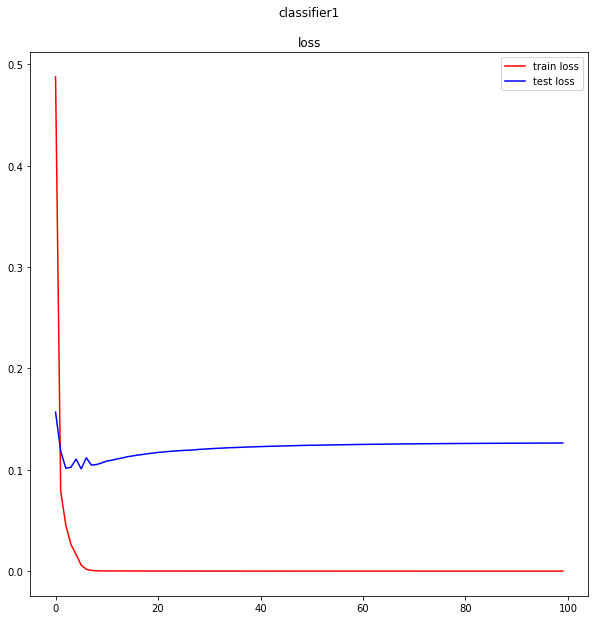

In [75]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_2,label="train loss",c="red")
plt.plot(loss_test_2,label="test loss",c="blue")
plt.title("classifier1\n\nloss")
plt.legend()
plt.plot()

[]

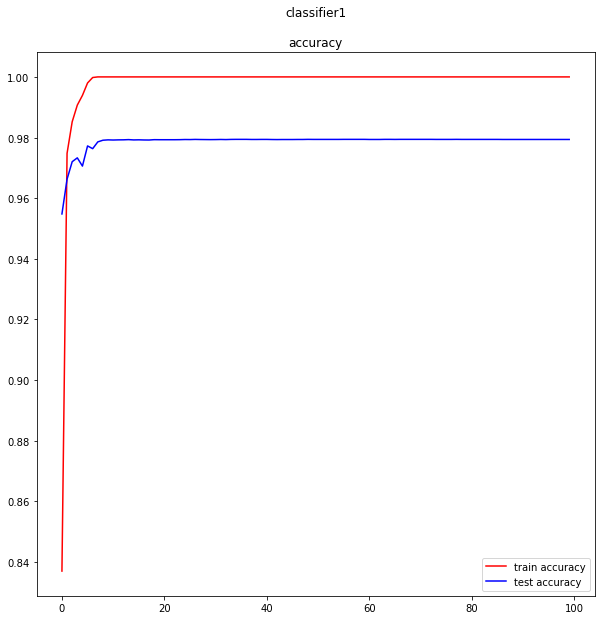

In [76]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_2,label="train accuracy",c="red")
plt.plot(acc_test_2,label="test accuracy",c="blue")
plt.title("classifier1\n\naccuracy")
plt.legend()
plt.plot()

In [125]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        
        #Output Size = (W - F + 2P) / S + 1
        #input size = 28 * 28
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=(3,3), padding = 1), # (28 - 3  + 2)/1 + 1 = 28 * 28
            nn.MaxPool2d(2), # 14 * 14
            nn.Dropout(),
            nn.ReLU(),
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(20, 20, kernel_size=(3,3), padding = 1), #14 * 14        
            nn.MaxPool2d(kernel_size=(2,2)), # 7 * 7
            nn.Dropout(),
            nn.ReLU(),
        )
        
        self.conv_3 = nn.Sequential(
            nn.Conv2d(20, 10, kernel_size=(3,3)), # (7 - 3) + 1 = 5 * 5
            nn.Dropout(),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            #input = 5 * 5 *10
            nn.Linear(250, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
        self._initialize_weight() 

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(-1, 250)
        x = self.fc(x)
        return x
    
    def _initialize_weight(self):

        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))

                if m.bias is not None:

                    m.bias.data.zero_()

            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                
                if m.bias is not None:

                    m.bias.data.zero_()

batch_size = 32
epoch = 50
learning_rate_value = 0.5
weight_decay = 0.5

In [126]:
batch_size = 32
epoch = 50
learning_rate_value = 0.5
weight_decay = 0.5

In [127]:
classifier3 = Model3().to("cuda")

In [17]:
loss_train_3, loss_test_3, acc_train_3, acc_test_3, best_3 = startTraining(batch_size,epoch,learning_rate_value, "SGD", weight_decay, classifier3)

NameError: name 'classifier3' is not defined

too many parameters.... learning process does not advance

In [9]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        
        #Output Size = (W - F + 2P) / S + 1
        #input size = 28 * 28
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(3,3), padding = 1), # (28 - 3  + 2)/1 + 1 = 28 * 28
            nn.MaxPool2d(2), # 14 * 14
            nn.Dropout(),
            nn.ReLU(),
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size=(3,3), padding = 1), #14 * 14        
            nn.MaxPool2d(kernel_size=(2,2)), # 7 * 7
            nn.Dropout(),
            nn.ReLU(),
        )
        
        self.conv_3 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size=(3,3)), # (7 - 3) + 1 = 5 * 5
            nn.Dropout(),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            #input = 5 * 5 *32
            nn.Linear(125, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(16, 10),
            nn.Softmax(dim=1)
        )
        
        self._initialize_weight() 

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(-1, 125)
        x = self.fc(x)
        return x
    
    def _initialize_weight(self):

        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                
                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))

                if m.bias is not None:

                    m.bias.data.zero_()

            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
                
                if m.bias is not None:

                    m.bias.data.zero_()

In [12]:
classifier4 = Model4().to("cuda")

In [14]:
batch_size = 32
epoch = 50
learning_rate_value = 0.1
weight_decay = 0.6

In [ ]:
loss_train_4, loss_test_4, acc_train_4, acc_test_4, best_4 = startTraining(batch_size,epoch,learning_rate_value, "SGD", weight_decay, classifier4)

start training for SGD


In [ ]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_3,label="train loss",c="red")
plt.plot(loss_test_3,label="test loss",c="blue")
plt.title("classifier1\n\nloss")
plt.legend()
plt.plot()

In [ ]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_3,label="train accuracy",c="red")
plt.plot(acc_test_3,label="test accuracy",c="blue")
plt.title("classifier1\n\naccuracy")
plt.legend()
plt.plot()

# Outputs

# 1. Plot the training and testing losses over epochs [2pt]

[]

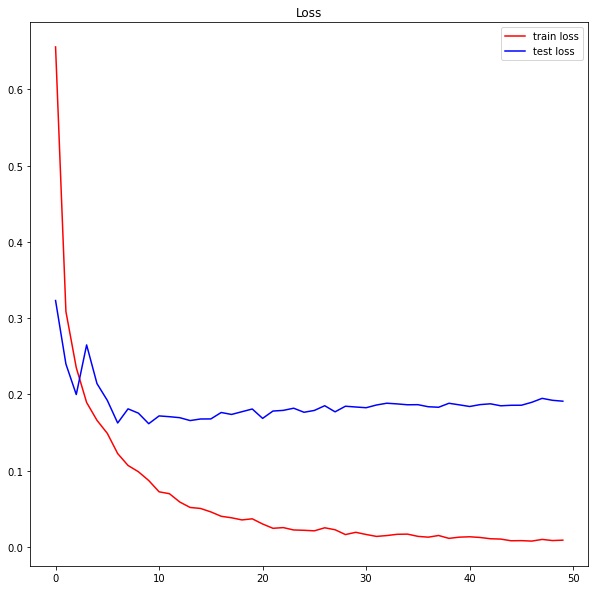

In [173]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_sgd2,label="train loss",c="red")
plt.plot(loss_test_sgd2,label="test loss",c="blue")
plt.title("Loss")
plt.legend()
plt.plot()

# 2. Plot the training and testing accuracies over epochs [2pt]

[]

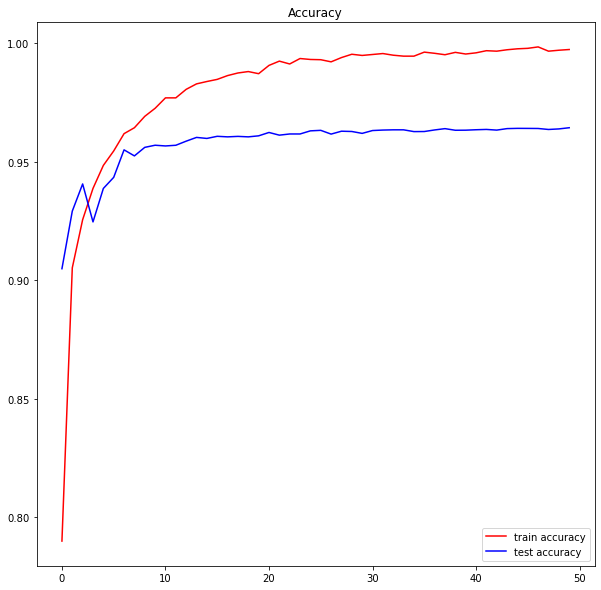

In [175]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_sgd2,label="train accuracy",c="red")
plt.plot(acc_test_sgd2,label="test accuracy",c="blue")
plt.title("Accuracy")
plt.legend(loc=4)
plt.plot()

# 3. Print the final training and testing losses at convergence [2pt]

In [171]:
print("training loss  ",loss_train_sgd2[49])
print("testing loss   ",loss_test_sgd2[49])

training loss   0.008669205423893945
testing loss    0.1909789605850897


# 4. Print the final training and testing accuracies at convergence [20pt]

In [176]:
print("training accuracy  ",acc_train_sgd2[49])
print("testing accuracy   ",acc_test_sgd2[49])

training accuracy   0.9972999691963196
testing accuracy    0.9643000364303589
